# preliminaries

## load modules

In [188]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data
import random
import hdbscan
import numpy as np
import pandas as pd

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

# custom modules
from src import annotation, parameters, segmentation, spectrogramming 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load path variables

In [134]:
# to do: put these in a paths.py file and run it
all_wav_raw = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/'
all_bg_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/background_clips/'
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'


# generate hdbscan labels

In [135]:
#get the final umap embeddings
coords_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_coordinates/'
umap_embeddings = os.listdir(coords_dir)
print('available embeddings:')
for i in [i for i in umap_embeddings if i.endswith('feather')]: print(i)

available embeddings:
BW_30130x128x128_version5.feather
PO_10468x128x128_version5.feather
IS_3755x128x128_version5.feather
GO_66868x128x128_version5.feather
SW_27289x128x128_version5.feather
MZ_12045x128x128_version5.feather
LL_18371x128x128_version5.feather
MU_26543x128x128_version5.feather
LO_19429x128x128_version5.feather
NB_34079x128x128_version5.feather
BK_42244x128x128_version5.feather


In [136]:
#choose the species to process from the above list get the .feather file with each spectrogram, its source_file name, and its umap coordinates
species = 'BW'

coords = [i for i in umap_embeddings if i.startswith(species)][0]
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/'
save_name_root = coords.split(('.'))[0]

print('getting umap embedding for', coords)
print('files associated with this embedding with have the prefix', save_name_root)
df_umap = pd.read_feather(coords_dir + coords)

getting umap embedding for BW_30130x128x128_version5.feather
files associated with this embedding with have the prefix BW_30130x128x128_version5


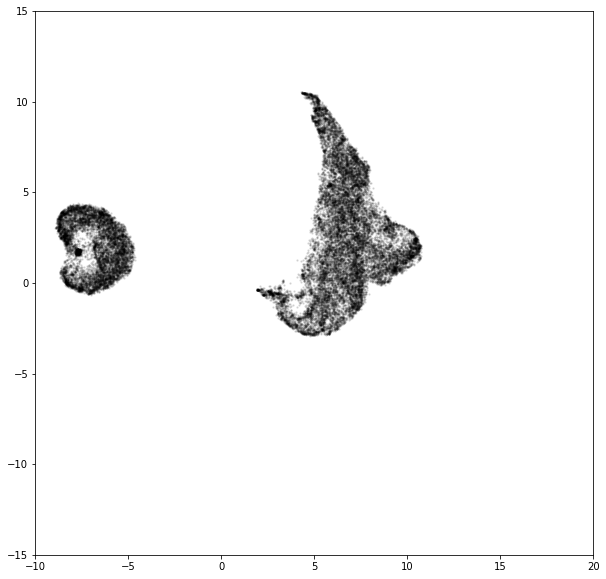

In [137]:
#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

pups = [i.split('_clip')[0] for i in df_umap['source_file']]
colmap = {name: n for n, name in enumerate(set(pups))}
c = [colmap[name] for name in pups]
ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = 'k',
    s = 2,
    alpha = .1, 
    cmap='viridis')

xlims = [-10,20]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)

plt.show()

# get cluster labels

In [138]:
#do SDBSCAN on UMAP coordinate JUST to separate the two clusters

data=df_umap[['umap1', 'umap2']]

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, allow_single_cluster=True).fit(data)
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

df_umap['label'] = clusterer.labels_


Text(0.5, 1.0, 'cluster_label=1')

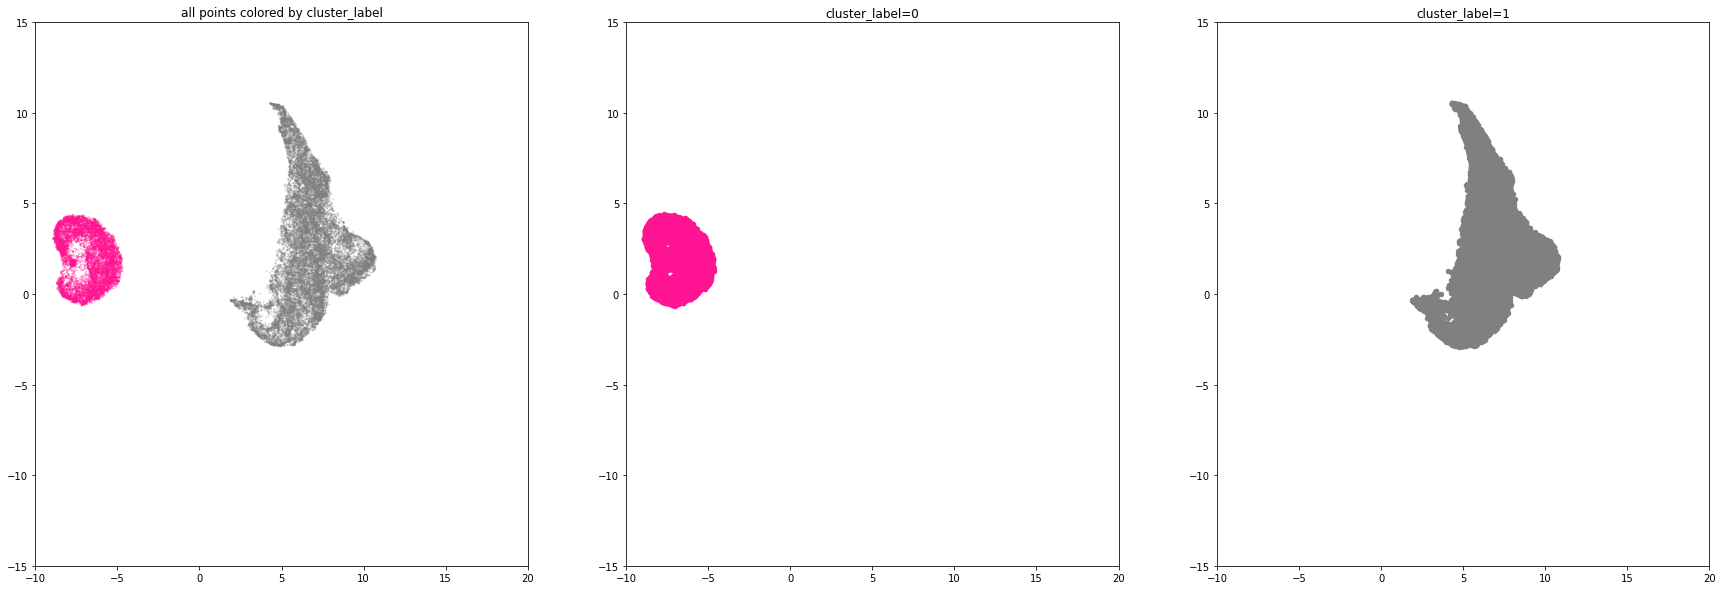

In [139]:
#show the umap plot with cluster labels and verify they correspond exactly to the clusters you see
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax3.set_xlim(xlims)
ax3.set_ylim(ylims)

ax1.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = cluster_colors,
    s = 1,
    alpha = .25)

ax1.set_title('all points colored by cluster_label')

ax2.scatter(
    df_umap['umap1'].loc[df_umap['label']==0],
    df_umap['umap2'].loc[df_umap['label']==0],
    c = 'deeppink',
    s = 20,
    alpha = 1)
ax2.set_title('cluster_label=0')

ax3.scatter(
    df_umap['umap1'].loc[df_umap['label']==1],
    df_umap['umap2'].loc[df_umap['label']==1],
    c = 'grey',
    s = 20,
    alpha = 1)
ax3.set_title('cluster_label=1')

In [140]:
#count vocalizations
print('label=0:', len(df_umap.loc[df_umap['label'] == 0]))
print('label=1:', len(df_umap.loc[df_umap['label'] == 1]))

label=0: 9582
label=1: 20548


In [141]:
#delete?

# #save this record that the clusterer worked as expected
# if save_name_root+'_labeled.jpeg' not in os.listdir(save_dir):
#     plt.savefig(save_dir+save_root+'_labeled.jpeg', dpi=600)
#     print('saved to ', save_dir+save_root+'_labeled.jpeg')
# else: 
#     print('file already exists.')

In [142]:
#delete?

# #save the new dataframe with spectrograms, source_files, umap_coordinates, an labels

# if save_name_root+'_labeled.feather' not in os.listdir(save_dir):
#     df_umap.to_feather(save_dir+save_root+'_labeled.feather')
#     print('saved to ', save_dir+save_root+'_labeled.feather')
# else: 
#     print('file already exists.')

# generate human labels

In [143]:
# check which sampling params and iterations already exist
print('available sampling parameters and iterations (species_label_iteration.json):')
for i in os.listdir(params_save_dir): print('\t',i)

available sampling parameters and iterations (species_label_iteration.json):
	 BW_hdbscanlabel1_iteration1.json
	 BW_background_iteration1.json
	 BW_hdbscanlabel0_iteration1.json
	 BW_hdbscanlabel0_iterationtest_20230111.json
	 BW_hdbscanlabel0_iteration2.json


In [144]:
#make the directories you need 

#Note: set iteration_number to iteration1 (or something) if this is the first time annotating this embedding
#update iteration_number if you want to go back and annotate more vocalizations and keep them 
#separate from previous annotations

#set the iteration number
iteration_number = 'test_20230111'

#make the directories
annotation.make_annotations_directories(save_dir=save_dir, 
                                         iteration=iteration_number)

annotations directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/00_params

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress/hdbscanlabel0

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress/hdbscanlabel0/test_20230111

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress/hdbscanlabel1

00_params directory already exists at /n/hoekstra_lab_tier1/Users/nj

In [145]:
#load the labeled spectrogram embeddings
labeled_embedding = [save_dir+i for i in os.listdir(save_dir) if i.endswith('.feather')][0]
print('getting umap embedded spectrograms with labels for', labeled_embedding)
umap_labeled = pd.read_feather(labeled_embedding)
print('done.')

getting umap embedded spectrograms with labels for /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/BW_30130x128x128_version5_labeled.feather
done.


In [146]:
#spot check number of labels
umap_labeled['label'].unique()

array([1, 0])

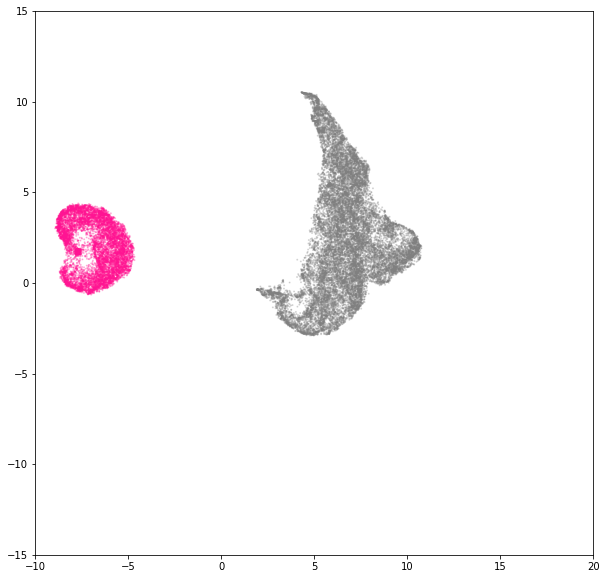

In [147]:
#show the labeled embedding
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in umap_labeled['label']]
plt.figure(figsize=(10,10))
xlims = [-10,20]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
plt.scatter(
    umap_labeled['umap1'],
    umap_labeled['umap2'],
    c = cluster_colors,
    s = 1,
    alpha = .25)

In [148]:
#or save new parameters after confirming twice you want to overwrite
clips_dir = all_voc_clips_dirs+species+'/'
print('clips_dir is', clips_dir)

#set the parameters
sampling_params = {'species': species,
                   'num_to_sample':6000, 
                   'random_state':123456, 
                   'hdbscan_label':0, 
                   'sampling_iteration':iteration_number, 
                   'clips_dir':clips_dir, 
                   'type':'sampling vocalizations from umap'}

# #set paths
params_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/00_params/'
params_save_name = sampling_params['species'] + '_hdbscanlabel'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])

#save
parameters.save_parameters(params = sampling_params,
                           save_dir=params_save_dir, 
                           save_name=params_save_name)
    

clips_dir is /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/BW/
This file already exists in save_dir: BW_hdbscanlabel0_iterationtest_20230111
overwrite? y/nn
ok - no file saved


# choose parameters for hand labeling

In [149]:
# check which sampling params and iterations already exist
print('available sampling parameters and iterations (species_label_iteration.json):')
for i in os.listdir(params_save_dir): print('\t',i)

available sampling parameters and iterations (species_label_iteration.json):
	 BW_hdbscanlabel1_iteration1.json
	 BW_background_iteration1.json
	 BW_hdbscanlabel0_iteration1.json
	 BW_hdbscanlabel0_iterationtest_20230111.json
	 BW_hdbscanlabel0_iteration2.json


In [150]:
#decide to save or not
save = False

#choose your sampling parameters from the list above (exclude .json extension)
params_to_load = 'BW_hdbscanlabel0_iterationtest_20230111'

#downsample 
sampling_params = parameters.load_parameters(save_dir=params_save_dir, #get the parameters
                                             save_name=params_to_load)

if sampling_params['species'] not in ['MU', 'MZ']: #if not MU or MZ, sample from a specific label only
    ds_df = annotation.sample_vocs(frame = umap_labeled, 
                                   num_to_sample = sampling_params['num_to_sample'], 
                                   label_to_sample = sampling_params['hdbscan_label'], 
                                   random_state = sampling_params['random_state'])

if sampling_params['species'] in ['MU', 'MZ']: #if MU or MZ, sample from all vocs
    ds_df = umap_labeled.sample(n=sampling_params['num_to_sample'], 
                                random_state =  sampling_params['random_state'])
    
ds_df = ds_df.reset_index(drop=True)


#save if you want
df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/hdbscan_label_'+str(sampling_params['hdbscan_label'])+'/'
df_save_name = sampling_params['species']+'_'+'downsampled_for_labeling_'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])+'.feather'
if save:
    assert os.path.exists(os.path.join(df_save_dir))
    ds_df.to_feather(os.path.join(df_save_dir+df_save_name))
    print('saved sampled vocalizations to:\n\t', os.path.join(df_save_dir+df_save_name))
else:
    print('\nnothing saved')

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/00_params/BW_hdbscanlabel0_iterationtest_20230111

nothing saved


In [151]:
#load sampled vocalizations
#ds_df = pd.read_feather(os.path.join(df_save_dir+df_save_name))

#check how many are from pups in the test set
test_df = pd.read_csv(test_set_path)
in_test_set = annotation.check_test_set(ds_df, test_df)
print(len(in_test_set), 'vocs come from pups in the test set')
print('dropping them...')

#drop them
ds_df = ds_df.loc[~ds_df['source_file'].isin(in_test_set)]
print('dropped', len(in_test_set), 'vocs...')
print('there are', len(ds_df), 'remaining...')
print('done.')

0 vocs come from pups in the test set
dropping them...
dropped 0 vocs...
there are 6000 remaining...
done.


In [152]:
#TO DO this only checks one or two previous iteratons. Would be better if it checked an arbitrary number.

#if this is iteration 2, check how many are from pups in previous annotations
species = sampling_params['species']
iteration1_source_files = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/hdbscanlabel0/iteration1/completed_source_files.npy'
iteration1_source_files = np.load(iteration1_source_files)

#MU has thre iterations
if sampling_params['species'] == 'MU':
    iteration2_source_files = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/hdbscanlabel0/iteration2/completed_source_files.npy'
    iteration2_source_files = np.load(iteration2_source_files)
    already_done = [i for i in ds_df['source_file'] if (i in iteration1_source_files) or (i in iteration2_source_files)]   

already_done = [i for i in ds_df['source_file'] if i in iteration1_source_files]   
ds_df = ds_df.loc[~ds_df['source_file'].isin(already_done)]
print(len(already_done), 'vocs are already annotated')
print('dropping them...')
print('there are', len(ds_df), 'remaining...')
print('done.')


1548 vocs are already annotated
dropping them...
there are 4452 remaining...
done.


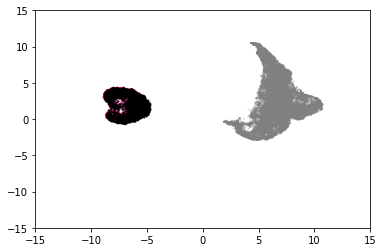

In [153]:
# plot them on top of all vocs
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in umap_labeled['label']]

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)

plt.scatter(
    umap_labeled['umap1'],
    umap_labeled['umap2'],
    c = cluster_colors,
    s = .7,
    alpha = .25)

plt.scatter(
    ds_df['umap1'],
    ds_df['umap2'],
    c = 'k',
    s = 1,
    alpha = .5)

loading saved annotations...
you already annotated 2 vocalizations from this species, label, and iteration...
saving progress...
vocalization 2 of 4452 ...
BW_29483x28930_ltr1_pup3_ch4_6100_f_285_291_fr0_p13_2021-10-20_08-55-30_clip_662.wav


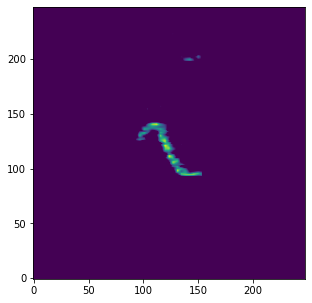

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotatedexit
exiting...you've annotated 2 wav clips.
returning the labeled vocalizations to you...
done.


In [155]:
# now hand annotate them - this is easiest if this is the last cell in the notebook - consider temporaroly moving it there

#for viewing specs with different param than used in embedding
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': .1, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
    'fs': 250000, # audio samplerate
    'downsample_by':2, #2 means take every other pixel from the original spectrogram
    'log_resize_scaling_factor':None, 
    'fill_value': .1,
    'max_dur':.1,
    'num_time_bins':248,
    'num_freq_bins':248,
    'spec_max_val':10,
    'interpolate':True, 
    'noise_floors_path':None
}

#interactive annotation
in_progress_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/in_progress/'+'hdbscanlabel'+str(sampling_params['hdbscan_label'])+'/'+str(sampling_params['sampling_iteration'])+'/'


non_spec_columns = ['source_file', 'umap1', 'umap2', 'label']
df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/hdbscan_label_'+str(sampling_params['hdbscan_label'])+'/'
df_save_name = sampling_params['species']+'_'+'hdbscan_label'+str(sampling_params['hdbscan_label'])+str(sampling_params['sampling_iteration'])+'.feather'
hand_labeled_df = annotation.annotations_from_umap(downsampled_frame = ds_df, 
                                                   num_freq_bins=128, 
                                                   num_time_bins=128, 
                                                   non_spec_columns=non_spec_columns, 
                                                   sampling_params=sampling_params, 
                                                   clips_dir=clips_dir, 
                                                   in_progress_dir = in_progress_dir,
                                                   spec_type='from_wav', 
                                                   df_save_dir = df_save_dir, 
                                                   df_save_name = df_save_name, 
                                                   spec_params=spec_params)




# generate labeled background audio

In [159]:
# check which sampling params and iterations already exist
bg_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/'
print('available sampling parameters and iterations (species_label_iteration.json):')
for i in [i for i in os.listdir(bg_dir) if i.endswith('.json')]: print('\t',i)

# #check if any background params exist for this species
# species = 'BW'
# bg_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/'
# sorted(os.listdir(bg_dir))

available sampling parameters and iterations (species_label_iteration.json):
	 BW_background_iteration2.json
	 BW_background_iteration1.json


In [459]:
#delete?

# temp = pd.read_feather(bg_dir+'all_background_cleaned_round2.feather')
# temp['vocalizations_present?'].unique()

array(['no_voc'], dtype=object)

In [449]:
#delete

# os.remove(bg_dir+'NB_27531x28557_ltr2_pup3_ch4_4900_m_331_292_fr0_p9_2021-11-01_09-28-29_background.feather_background.feather')
# os.remove(bg_dir+'NB_27531x28557_ltr2_pup3_ch4_4900_m_331_292_fr0_p9_2021-11-01_09-28-29_background_cleaned.feather')

In [161]:
#set new background labeleing parameters and confirm overwrite twice
bg_clips_dir = all_bg_clips_dirs+species+'/'
bg_labeling_params = {'species': species, 
                   'sampling_iteration':iteration_number, 
                   'clips_dir':bg_clips_dir, 
                   'nperseg': 512,
                   'noverlap': 512//2, 
                   'type': 'background'
                   }

#choose save location and name
bg_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/'
save_name = bg_labeling_params['species'] + '_background'+str(bg_labeling_params['sampling_iteration'])

#save the parameters
parameters.save_parameters(params = bg_labeling_params,
                           save_dir=bg_dir, 
                           save_name=save_name)

#if a directory doesn't exist for this iteration make it
inprogress_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/background/'
iteration_dir = 'iteration'+str(bg_labeling_params['sampling_iteration'])
if iteration_dir not in os.listdir(inprogress_dir):
    os.mkdir(inprogress_dir+'iteration'+str(bg_labeling_params['sampling_iteration']))



making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/background/BW_backgroundtest_20230111


In [168]:
#show available labeling parameters
print('available parameters for annotating background (species_label_iteration.json):')
for i in [i for i in os.listdir(bg_dir) if i.endswith('.json')]: print('\t', i)

available parameters for annotating background (species_label_iteration.json):
	 BW_background_iteration2.json
	 BW_background_iteration1.json
	 BW_backgroundtest_20230111.json


In [169]:
#choose the parameters you want to use (exclude .json file extension)
bg_parameters_to_load = 'BW_backgroundtest_20230111'

#load the labeling parameters
bg_labeling_params = parameters.load_parameters(save_dir=bg_dir, 
                                                save_name=bg_parameters_to_load)

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/background/BW_backgroundtest_20230111


In [172]:
#choose the pup to annoatate
pups = [i.split('_backgroundclip')[0] for i in os.listdir(bg_labeling_params['clips_dir'])]
pup = random.sample(pups, 1)[0]


################################
labeling background from pup BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr0_p5_2022-01-16_11-04-47 
################################

loading saved annotations...
you already annotated 8 clips...amounting to 3.6231519999999997 seconds of audio from this pup...

[]
0 have been annotated from other iterations
3.6231519999999997 seconds of audio annotated from this pup...
saving progress...

BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr0_p5_2022-01-16_11-04-47_backgroundclip_169.wav
		clip duration (s) 0.0924


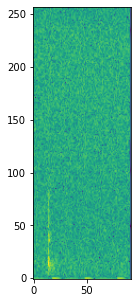

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
3.7155519999999997 seconds of audio annotated from this pup...
saving progress...

BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr0_p5_2022-01-16_11-04-47_backgroundclip_36.wav
		clip duration (s) 1.288436


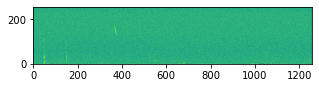

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exitq
		ok - ignoring
3.7155519999999997 seconds of audio annotated from this pup...
saving progress...

BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr0_p5_2022-01-16_11-04-47_backgroundclip_113.wav
		clip duration (s) 0.104688


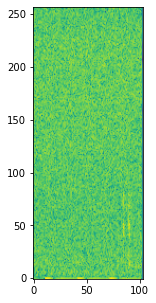

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
3.8202399999999996 seconds of audio annotated from this pup...
saving progress...

BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr0_p5_2022-01-16_11-04-47_backgroundclip_39.wav
		clip duration (s) 0.100592


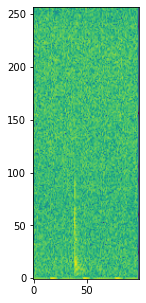

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exite
exiting...
you annotated 11 clips amounting to 3.8202399999999996 seconds of background audio...
returning the labeled vocalizations to you...


In [177]:
#annotate
in_progress_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+bg_labeling_params['species']+'/annotations/in_progress/'+'background'+'/'+'iteration'+str(bg_labeling_params['sampling_iteration'])+'/'
label_save_name = pup+'_background.feather'
bg_annotations = annotation.annotations_from_background(species=bg_labeling_params['species'], 
                                                        bg_labeling_params = bg_labeling_params, 
                                                        bg_clips_dir=bg_labeling_params['clips_dir'], 
                                                        df_save_dir=bg_dir, 
                                                        df_save_name=label_save_name, 
                                                        pup=pup, 
                                                        inprogress_dir=inprogress_dir)


In [178]:
bg_annotations

# #check for duplicates
# print(len(bg_annotations))
# print(len(bg_annotations.drop_duplicates()))

,source_file,vocalizations_present?,duration_s,start_frame,stop_frame
0,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.149748,2500,37437
1,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.700320,127500,302580
2,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,NOT_ANNOTATED,0.000000,0,0
3,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.102640,2500,25660
4,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,1.049756,27500,289939
5,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.975088,2500,243772
6,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.098544,2500,24636
7,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.547056,2500,136764
8,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,no_voc,0.092400,2500,23100
9,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,voc,0.000000,0,0


In [179]:
#remove rows that contain vocalizations ("clean")
to_process = [i for i in os.listdir(bg_dir) if '_background.feather' in i and 'cleaned' not in i]
for pup in to_process:
    cleaned_df_save_name = pup.split('.')[0]+'_cleaned_round2'+'.feather'
    temp = pd.read_feather(bg_dir+pup)
    temp = temp.loc[temp['vocalizations_present?'] == 'no_voc']
    temp = temp.reset_index(drop=True)
    temp.to_feather(bg_dir+cleaned_df_save_name)


In [181]:
os.listdir(bg_dir)

['BW_28988x28929_ltr4_pup3_ch4_3200_f_356_281_fr0_p5_2021-12-05_10-36-57_background_cleaned_round2.feather',
 'BW_28988x28929_ltr4_pup1_ch2_3400_f_364_293_fr0_p5_2021-12-05_10-36-57_background_cleaned.feather',
 'BW_28987x28928_ltr2_pup4_ch5_5900_m_307_290_fr0_p11_2021-08-21_10-58-52_background.feather',
 'BW_28987x28928_ltr4_pup3_ch4_4700_m_330_315_fr0_p9_2021-12-25_09-50-00_background_cleaned_round2.feather',
 'BW_29483x28930_ltr3_pup2_ch3_6500_f_331_326_fr0_p13_2021-12-13_09-54-15_background.feather',
 'BW_31386x31477_ltr1_pup2_ch3_3600_m_362_293_fr0_p5_2022-01-16_11-04-47_background.feather',
 'BW_28987x28928_ltr2_pup3_ch4_6100_f_309_300_fr0_p11_2021-08-21_10-58-52_background_cleaned.feather',
 'BW_29916x29806_ltr1_pup2_ch3_2400_m_323_269_fr0_p3_2022-02-17_11-10-49_background.feather',
 'BW_background_iteration2.json',
 'all_background_cleaned_round2.feather',
 'BW_28988x28929_ltr1_pup3_ch4_6100_f_311_295_fr0_p11_2021-07-20_10-00-42_background.feather',
 'BW_31386x31477_ltr1_pup2_c

In [189]:
# combine annotations from different pups into a single dataframe
include_string = '20230111' 
file_format = '.feather'
combined_df = parameters.combine_dataframes(source_dir = bg_dir, 
                                            save_dir = bg_dir, 
                                            save_name = 'all_background_cleaned_test20230111',
                                            include_string = include_string, 
                                            file_format = file_format)

#check there are no duplicates
dropped_combined_df = combined_df.drop_duplicates()
print('\nTotal of', sum(combined_df['duration_s']), 'seconds annotated for', species, 'before duplicates dropped')
print('\nTotal of', sum(dropped_combined_df['duration_s']), 'seconds annotated for', species, 'after duplicates dropped')

ValueError: No objects to concatenate

In [455]:
#check how much background you have actually annotated and if there are any dublicates
total_annotated = []
to_check = [i for i in os.listdir(bg_dir) if i.endswith('.feather')]
for i in sorted(to_check):
    temp = pd.read_feather(bg_dir+i)
    print(i)
    print('len:', len(temp))
    print('num duplicates:', sum(temp.duplicated(subset='source_file')))
    print('total time annotated:', sum(temp['duration_s'].loc[temp['vocalizations_present?'] == 'no_voc']))
    total_annotated.append(sum(temp['duration_s'].loc[temp['vocalizations_present?'] == 'no_voc']))
print(sum(total_annotated))

# clean labeled vocalizations and generate wav files and annotations

## make a datframe for each vocalization you labeled

In [1356]:
#combine all the iterations

#choose the species
species_list = ['BW']
hdbscan_label = '1'

#bad pups - these are pups I discovered had recording artefacts (ie many vertical lines) while annotating
bad_pups = ['BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37', 
            'NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13', 
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58', 
            'MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11', 
            'MU_31063x31066_ltr1_pup8_ch8_1600_m_338_253_fr0_p3_2021-09-23_12-31-47', 
            'MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11', 
            'MU_31063x31066_ltr2_pup7_ch8_4400_f_339_305_fr0_p11_2022-01-24_09-30-16', 
            'MU_31063x31066_ltr1_pup8_ch8_1600_m_338_253_fr0_p3_2021-09-23_12-31-47']

for species in species_list:
    print(species)
    df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/hdbscan_label_'+hdbscan_label+'/'
    if hdbscan_label == '0':
        if species == 'MU':
            iteration1 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
            iteration2 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration2.feather'))
            iteration3 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration3.feather'))
            all_vocs = pd.concat([iteration1,iteration2,iteration3])
            
        elif species == 'LO': #LO only has one iteration 
            all_vocs = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
        else:  
            iteration1 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
            iteration2 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration2.feather'))
            all_vocs = pd.concat([iteration1,iteration2])

        print('dropping', sum(all_vocs.duplicated(subset='source_file')), 'duplicate rows...')
        all_vocs = all_vocs.drop_duplicates(subset=['source_file'])
        all_vocs = all_vocs.reset_index(drop=True)  
        all_vocs['pup'] = [i.split('_clip')[0] for i in all_vocs['source_file']]
        print('dropping', len(all_vocs.loc[all_vocs['pup'].isin(bad_pups)]), 'vocs from bad pups...')
        all_vocs = all_vocs.loc[~all_vocs['pup'].isin(bad_pups)]
        all_vocs = all_vocs.reset_index(drop=True)

        print('saving...')
        all_vocs.to_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_all.feather'))

        print('done.')

    elif hdbscan_label == '1': #only Pero have a label 1 and they all only have 1 iteration of annotation right now
        if species in ['MU', 'MZ']:
            continue

        elif species in ['BW', 'BK', 'SW', 'NB', 'PO', 'LO', 'GO', 'LL']:
            all_vocs = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
            
            print('dropping', sum(all_vocs.duplicated(subset='source_file')), 'duplicate rows...')
            all_vocs = all_vocs.drop_duplicates(subset=['source_file'])
            all_vocs = all_vocs.reset_index(drop=True)

            all_vocs['pup'] = [i.split('_clip')[0] for i in all_vocs['source_file']]
            print('dropping', len(all_vocs.loc[all_vocs['pup'].isin(bad_pups)]), 'vocs from bad pups...')
            all_vocs = all_vocs.loc[~all_vocs['pup'].isin(bad_pups)]
            all_vocs = all_vocs.reset_index(drop=True)

            print('saving...')
            all_vocs.to_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_all.feather'))

            print('done.')


BW
dropping 0 duplicate rows...
dropping 0 vocs from bad pups...
saving...
done.


# optional: generate wav files in which annotated vocs are interleved with random background and save corresponding csvs of their start and stop times

In [1357]:
#choose the species and label
hdbscan_label = '1'
species_list = ['BW']

#this is the a blank (no mouse in the box) 25 ms file from the recording set up used to record 'BK', 'SW', 'NB', 'PO', 'LO', 'GO', 'LL', 'MU'
lab_spacer_wav = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/00_params/spacer_ch2_background_2019-09-04_13-16-26_25ms.wav'

#this is a 25 ms clip with no vocalizatons from a barn recording (mouse was in the box but I verified this clip has no vocalizations)
wild_spacer_wav = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/00_params/MZ_box20_p7_pup2_2022-07-21_12-38-47_25ms_silence.wav'

for species in species_list:
    print(species)
    
    #get the dataframe that has all of the annotations (no need to split into vocal and nonvocal)
    df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/hdbscan_label_'+hdbscan_label
    df_save_name = species+'_'+'hdbscan_label'+hdbscan_label+'_all'+'.feather'
    hand_labeled_df = pd.read_feather(os.path.join(df_save_dir,df_save_name))

    #make sure you have all the annotations you expect
    if species in ['BW', 'BK', 'SW', 'NB', 'PO', 'LO', 'GO', 'LL']:
        print(hand_labeled_df['human_label'].unique())
        human_labels = list(hand_labeled_df['human_label'].unique())
        
    elif species in ['MU', 'MZ']: # these don't have cries
        set(hand_labeled_df['human_label'].unique()) == set(['whistle', 'scratch', 'none'])
        human_labels = ['whistle', 'scratch']

    voc_clips_dir = os.path.join(all_voc_clips_dirs,species)+'/'

    #for each label, get it from the big dataframe then save the annotations and concatenate the wav file
    for human_label in human_labels:

        #get the clips with the current label
        cleaned_voc = hand_labeled_df.loc[hand_labeled_df['human_label'] == human_label]
        #define the save directory and save name
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/for_das/'
        annotations_save_name = ('_').join([species,'hdbscanLabel',hdbscan_label,'humanLabel',cleaned_voc['human_label'].unique()[0],'25msspacer','annotations'])
        voc_clips_list = cleaned_voc['source_file']
        
        if species == 'MZ':
            spacer_wav = wild_spacer_wav
        else:
            spacer_wav = lab_spacer_wav

        #make the annotations and wav file
        df = concat_annotated_clips(voc_clips_dir = voc_clips_dir, 
                            voc_clips_list = voc_clips_list,
                            save_dir = save_dir, 
                            spacer_wav = spacer_wav,
                            save_name = annotations_save_name, 
                            label = human_label, 
                            margin = 0)
    
print('done.')


BW
['cry' 'none' 'scratch' 'whistle']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286/2286 [00:21<00:00, 104.50it/s]


done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 175.39it/s]


done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 182.81it/s]


done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.47it/s]


done.
done.


In [461]:
#write the human labeled wav file for the background
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ']

for species in species_list:
    bg_clips_dir = all_bg_clips_dirs + species + '/'
    bg_df_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/all_background_cleaned_round2.feather'
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/for_das/'
    save_name = species+'_'+'background_round2.wav'

    bg_df = pd.read_feather(bg_df_path)
    bg_df = bg_df.drop_duplicates(subset=['source_file']) #there shouldn't be any
    wav_from_background_annotations(frame=bg_df, 
                                    clips_dir=bg_clips_dir, 
                                    save_dir=save_dir, 
                                    save_name=save_name)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:15<00:00, 47.15it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:27<00:00, 28.69it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 706/706 [00:20<00:00, 34.67it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 556/556 [00:20<00:00, 27.04it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:14<00:00, 14.45it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 577/577 [00:18<00:00, 30.85it/s]


done.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:36<00:00, 43.27it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 540/540 [00:22<00:00, 23.92it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 577/577 [00:23<00:00, 24.71it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:33<00:00, 27.60it/s]


done.
